# Imaging Supernova

In this notebook, we will image a distant supernova event around the date of maximum magnitude. To fetch data, we will use the `astroquery` python package, particularly the CADC module, which queries data provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ).

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)


## 1. Introduction

The [Open Supernova Catalog](https://sne.space/) is an open data collection of supernova and their parameters such as position, redshifts, and light-curve shape. This tutorial will query this catalog for supernova with a low redshift. After selecting a supernova target, we query the CADC database for the target, then display some images.

## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 


## 3. Querying

### Find suitable targets
For this tutorial, we want to display type Ia low redshift supernova and its host galaxy in the CFHT Legacy Survey field. To find a suitable supernova, we can query the [Open Supernova Catalog](https://sne.space/) then refine the results to get a list of supernova with `claimedtype` of `Ia` and `redshift` between `0.2` and `0.3` that are part of the Supernova Legacy Survey (SNLS) where the `discoverdate` is before the `maxdate`. The [Open Supernova Catalog API](https://github.com/astrocatalogs/OACAPI) was used to build the catalog query.


In [1]:
from urllib.parse import urlencode

import pandas as pd

# We want results with claimedtype of Ia in csv format
params = {'claimedtype': 'Ia', 'format': 'csv'}
catalog_domain = 'https://api.sne.space/catalog'
query_str = urlencode(params)

# The 'first' paramter returns the first value in a list
url = '{}?{}&first'.format(catalog_domain, query_str)

# Grab the data from the url and convert to a pandas dataframe
sn_data = pd.read_csv(url)

# Define the min and max redshift range
z_min, z_max = 0.2, 0.3

# Select SNLS events in redshift range where discoverdate is before maxdate
sn_data = sn_data.dropna(subset=['discoverdate', 'maxdate', 'redshift'])
sn_data = sn_data[(sn_data['redshift'] > z_min)
                  & (sn_data['redshift'] < z_max)]
sn_data = sn_data[sn_data['event'].str.startswith('SNLS')]
sn_data = sn_data[sn_data['discoverdate'] < sn_data['maxdate']]

print('Query url: {}'.format(url))
print('Number of results: {}'.format(len(sn_data)))
sn_data

Query url: https://api.sne.space/catalog?claimedtype=Ia&format=csv&first
Number of results: 7


,event,alias,catalog,claimedtype,dec,discoverdate,discoverer,download,ebv,host,...,name,photolink,ra,radiolink,redshift,references,sources,spectralink,velocity,xraylink
11407,SNLS-03D4cj,SNLS-03D4cj,sne,Ia,-17:42:16.76,2003/08/26,Supernova Legacy Project,NaN,0.0225,[HSP2005] J221606.66-174216.72,...,SNLS-03D4cj,"42,-10.3,60.4",22:16:06.627,NaN,0.2700,"2010A&A...523A...7G,2005ApJ...634.1190H,2008Ap...",NaN,"2,-6.69,-5.91",70000.0,NaN
11422,SNLS-04D1dc,SNLS-04D1dc,sne,Ia,-04:18:42.5,2004/08/10,NaN,NaN,0.0221,[NSB2006] J022618.47-041843.2,...,SNLS-04D1dc,"75,-3.24,120",02:26:18.40,NaN,0.2110,"2010A&A...523A...7G,2009A&A...507...85B,2016A&...",NaN,1,56700.0,NaN
11516,SNLS-05D1by,SNLS-05D1by,sne,Ia,-04:12:04.02,2005/09/02,NaN,NaN,0.0240,NaN,...,SNLS-05D1by,"34,-6.14,67.6",02:24:35.437,NaN,0.2990,"2010A&A...523A...7G,2008A&A...477..717B,2016A&...",NaN,"1,-1.15",76700.0,NaN
11528,SNLS-05D1hk,SNLS-05D1hk,sne,Ia,-04:38:03.31,2005/11/29,NaN,NaN,0.0210,NaN,...,SNLS-05D1hk,"37,-22.2,193",02:24:39.176,NaN,0.2631,"2010A&A...523A...7G,2009A&A...507...85B,2008Ap...",NaN,"2,-17.8",68780.0,NaN
11532,SNLS-05D1iy,SNLS-05D1iy,sne,Ia,-04:25:21.29,2005/11/29,NaN,NaN,0.0222,NaN,...,SNLS-05D1iy,"33,-10.5,46.3",02:27:39.961,NaN,0.2478,"2010A&A...523A...7G,2008ApJ...674...51E,2016A&...",NaN,"1,-6.01",65310.0,NaN
11589,SNLS-05D3kx,SNLS-05D3kx,sne,Ia,+53:08:13.63,2005/06/08,NaN,NaN,0.0093,[NSB2006] J142150.02+530813.4,...,SNLS-05D3kx,"42,-13.2,193",14:21:50.019,NaN,0.2190,"2010A&A...523A...7G,2006AJ....132.1126N,2016A&...",NaN,NaN,58600.0,NaN
11685,SNLS-06D3fp,SNLS-06D3fp,sne,Ia,+52:53:49.79,2006/06/17,NaN,NaN,0.0072,NaN,...,SNLS-06D3fp,"32,-18.3,29",14:20:18.605,NaN,0.2680,"2010A&A...523A...7G,2011MNRAS.410.1262W,2016A&...",NaN,"1,-1.97",69900.0,NaN


Now that we have a list of suitable supernovae, we can get the area and date range that we need to query the CADC database for. Let's choose the first result from the `sn_data` table and extract it's R.A., Dec., and date of the maximum observation. We will also grab the name for plotting later. Using the R.A. and Dec. we can make a SkyCoord object, and using the maximum observation date, we can create a date window starting 20 days before and ending 100 days after to query inside of.

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta

# Select a supernova and gather data
sn = sn_data.iloc[0]
sn_name, sn_ra, sn_dec, sn_maxdate = sn['name'], sn['ra'], sn['dec'], sn[
    'maxdate']

# Build the SkyCoord object
coords = SkyCoord(sn_ra, sn_dec, unit=(u.hourangle, u.deg))

# Build the start and end date objects
days_before = 20.0
days_after = 100.0
maxdate = Time(sn_maxdate.replace('/', '-'), format='isot')
start_date = maxdate - TimeDelta(days_before, format='jd')
end_date = maxdate + TimeDelta(days_after, format='jd')

print('Supernova coordinates: {}'.format(coords))
print('Supernova max date: {}'.format(maxdate))
print('Query date range: {} to {}'.format(start_date, end_date))

Supernova coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (334.0276125, -17.70465556)>
Supernova max date: 2003-09-03T00:00:00.000
Query date range: 2003-08-14T00:00:00.000 to 2003-12-12T00:00:00.000


### Using ADQL
The CADC module has a `exec_sync` function which allows you to query the database using ADQL. It takes in a query string and returns a job which leads to the query results. In this tutorial, we want to query images that:
   * contain the supernova coordinates
   * have been taken in between the `start_date` and `end_date` calculated above
   * have the `r` band filter
   * have been collected by the Canada France Hawaii Telescope (CFHT)
   * have calibration level 2 or above
   * have `quality_flag` that is not junk

In addition to these results, we also want an image taken much after the supernova event has occurred, to give a good view of the host galaxy. So similarly, we will query the same coordinates, `r` filter, CFHT collection, etc, but the time the image is taken will be as new as possible.

Once we fetch the results, we will display a subset of the columns (since there are so many!). First, let's start with the query.

In [3]:
from astroquery.cadc import Cadc

# Build the query
query_outline = """SELECT {num} * FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID
WHERE (INTERSECTS( INTERVAL( {mjd_start}, {mjd_end} ), Plane.time_bounds_samples ) = 1 
    AND CONTAINS( POINT('ICRS', {ra}, {dec}), Plane.position_bounds ) = 1 
    AND LOWER(Plane.energy_bandpassName) LIKE '{filter}%' 
    AND collection = '{collection}'
    AND calibrationLevel >= {cal_level}
    AND (Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk'))
    ORDER BY time_bounds_lower {order}"""

# Select the parameters for the ADQL query
query_params = {
    'num': '',  # Restricts the number of results (empty string returns all)
    'mjd_start': start_date.mjd,
    'mjd_end': end_date.mjd,
    'ra': coords.ra.degree,
    'dec': coords.dec.degree,
    'filter': 'r',
    'collection': 'CFHT',
    'cal_level': 2,
    'order': 'ASC'  # Order the results from oldest to newest
}

# Instantiate the CADC module
cadc = Cadc()

# Run the query and fetch the results
results = cadc.exec_sync(query_outline.format(**query_params))

# Select a subset of columns to preview
columns_subset = [
    'productID', 'collection', 'energy_bandpassName', 'time_bounds_samples',
    'time_bounds_lower', 'time_exposure'
]

print('Total number of results: {}'.format(len(results)))

# Showing a sample of the results
results[columns_subset][0:5]

Total number of results: 80


productID,collection,energy_bandpassName,time_bounds_samples,time_bounds_lower,time_exposure
,,,m,d,s
bytes64,bytes32,bytes32,object,float64,float64
714734p,CFHT,r.MP9601,[[52873.4170719 52873.4212391801]],52873.4170719,360.05299999999994
714735p,CFHT,r.MP9601,[[52873.4227018 52873.426868906485]],52873.4227018,360.0380000000003
714736p,CFHT,r.MP9601,[[52873.4283271 52873.432494461114]],52873.4283271,360.05999999999995
714737p,CFHT,r.MP9601,[[52873.4340987 52873.43826614213]],52873.4340987,360.0669999999997
714738p,CFHT,r.MP9601,[[52873.4398189 52873.443986110644]],52873.4398189,360.0470000000003


Then we can query for the comparison image much after the supernova explosion.

In [4]:
from datetime import datetime

# Select the parameters for the ADQL query to get sn host galaxy much after event
# We select only one result where the start date is the end date of the previous query
query_params = {
    'num': 'TOP 1',  # Select only the first result
    'mjd_start': end_date.mjd,
    'mjd_end': Time(datetime.now(), format='datetime').mjd,
    'ra': coords.ra.degree,
    'dec': coords.dec.degree,
    'filter': 'r',
    'collection': 'CFHTMEGAPIPE',
    'cal_level': 2,
    'order': 'DESC'  # Order the results from newest to oldest
}

# Run the query and fetch the results
comparision_results = cadc.exec_sync(query_outline.format(**query_params),
                                     'sync')

comparision_results[columns_subset]

productID,collection,energy_bandpassName,time_bounds_samples,time_bounds_lower,time_exposure
,,,m,d,s
bytes64,bytes32,bytes32,object,float64,float64
QD4.07BQ10.R,CFHTMEGAPIPE,r.MP9601,[[54444.216558 54445.247345518525]],54444.216558,1499.0


## 4. Fetching Data
Now let's get access to the results, download them, and display them. We will use the `get_image_list` function to get cutout urls of the results. Since that function takes a table, we will stack the results and comparisons table. We also want to calculate the time difference between the time the image was captured and the supernova maximum date and append it to the results table.

In [5]:
from astropy.table import vstack

# Reduce results for easier displaying
interval = len(results) // 12

# Stack supernova and host galaxy results
results_subset = vstack([results[::interval], comparision_results])

# Calculate the time from maxdate for each result
results_subset['time_from_maxdate'] = [
    date_taken - maxdate.mjd
    for date_taken in results_subset['time_bounds_lower']
]

### Retriving Data with astropy.io
Using the `get_image_list` function, we will fetch the data access urls and then use the `astropy.io.fits` module to access the data.

In [6]:
import re
import warnings

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS

# Supress fits processing warnings
warnings.simplefilter('ignore')

data_list = []

# Grab cutout urls of the table of results around the supernova position
cutout_urls = cadc.get_image_list(results_subset, coords.icrs, 0.01*u.deg)

# Access the url and fetch the data
for cutout_url, time_from_maxdate in zip(cutout_urls,
                                         results_subset['time_from_maxdate']):
    try:
        with fits.open(cutout_url) as hdulist:
            wcs = WCS(hdulist[0].header)
            image_data = hdulist[0].data
            data_list.append({
                'image_data': image_data,
                'wcs': wcs,
                'time_from_maxdate': time_from_maxdate
            })
    except:
        print('Error: Problem with {}'.format(cutout_url))
        continue

print("Finished processing images.")

Finished processing images.


## 5. Plotting Results

Now that we have all the image data, we can begin to plot the data! First we clean the data and remove any incomplete or ill-formatted images.

Now that we have the image data and the coordinate data of all our cutouts, we can begin to plot the data! First we will grab the image data for all the results and check if it is valid. We will remove the images that have more than 5% blank pixels, as well as images with aspect ratio less than 0.8 and greater than 1.2. Then we will display the list of supernova, as well as the number of days to and from the maximum date.

In [7]:
import numpy as np


def clean_image_list(data_list):
    """Cleans out the incomplete and ill-formatted images and returns the datalist"""

    def exists(data):
        return data['image_data'] is not None

    def percent_nonzero_above_x(data, x=0.95):
        image_data = data['image_data']
        return np.count_nonzero(image_data) / image_data.size > x

    def square_image(data, ratio_bounds=(0.8, 1.2)):
        x, y = data['image_data'].shape
        return (x / y > ratio_bounds[0] and x / y < ratio_bounds[1])

    # Clean the images on number of nonzero pixels and aspect ratio
    return list(
        filter(
            lambda data: exists(data) and percent_nonzero_above_x(data) and
            square_image(data), data_list))


cleaned_data_list = clean_image_list(data_list)
print('Number of images pre-clean: {}'.format(len(data_list)))
print('Final number of cleaned images: {}'.format(len(cleaned_data_list)))

Number of images pre-clean: 15
Final number of cleaned images: 15


In this particular case, no images were removed during cleaning!

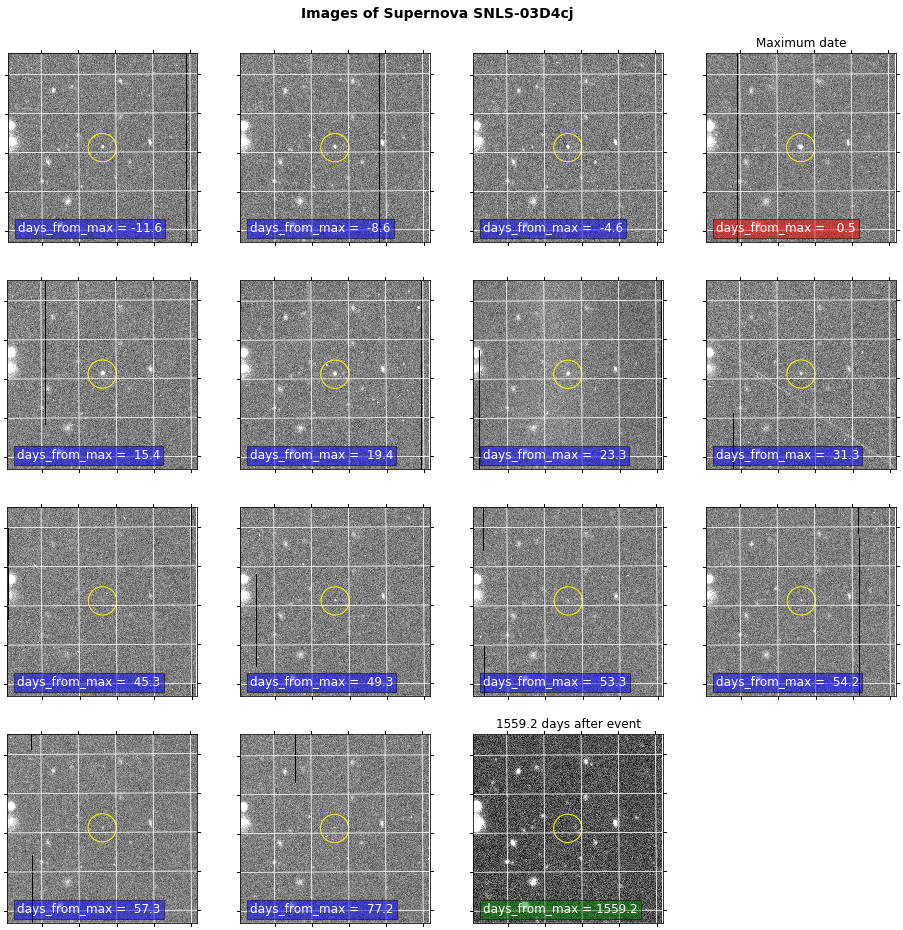

In [8]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval

np.seterr(divide='ignore', invalid='ignore')


def plot_image_list(data_list, coords, sn_name, geo=None):
    """ Plot the supernova image list"""

    # Build a layout if none is passed in
    if geo is None:
        geo = (len(data_list), 1)  # ncols, nrows

    # Find the brightest and dimest dates
    brightest_date = min(
        [abs(data['time_from_maxdate']) for data in data_list])
    dimmest_date = max([abs(data['time_from_maxdate']) for data in data_list])

    # Get the WCS for projection
    wcs_trans = data_list[0]['wcs']

    # Dynamically create figsize based on layout
    fig = plt.figure(figsize=(geo[0] * 4, geo[1] * 4))

    fig.suptitle('Images of Supernova {}'.format(sn_name),
                 fontsize=14,
                 fontweight='bold',
                 y=0.92)

    for idx, data in enumerate(data_list):
        ax = plt.subplot(geo[1],
                         geo[0],
                         idx + 1,
                         projection=wcs_trans,
                         facecolor='y')

        # Draw yellow circle around supernova position
        ax.scatter(coords.icrs.ra.degree,
                   coords.icrs.dec.degree,
                   transform=ax.get_transform('icrs'),
                   s=800,
                   edgecolor='yellow',
                   facecolor='none')

        # Normalize and plot the data
        image_data_norm = ImageNormalize(data['image_data'],
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())
        ax.imshow(data['image_data'],
                  norm=image_data_norm,
                  transform=ax.get_transform(data['wcs']),
                  cmap='gray')

        # Print days to date of maximum luminosity
        # Use red if closest to maxdate, green for comparison photo, and blue otherwise
        color = 'blue'
        if data['time_from_maxdate'] == brightest_date:
            ax.set_title('Maximum date')
            color = 'red'
        elif data['time_from_maxdate'] == dimmest_date:
            ax.set_title('{:5.1f} days after event'.format(
                data['time_from_maxdate']))
            color = 'green'
        ax.text(20,
                20,
                'days_from_max = {:5.1f}'.format(data['time_from_maxdate']),
                fontsize=12,
                color='white',
                bbox={
                    'facecolor': color,
                    'alpha': 0.5,
                    'pad': 3
                })

        # Add grid and remove axis labels
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_visible(False)
        dec.set_ticklabel_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')


ncols = 4
nrows = math.ceil(len(cleaned_data_list) / ncols)
plot_image_list(cleaned_data_list, coords, sn_name, geo=(ncols, nrows))